# Real and Fake Face detection
In this replository is a small application that uses a CNN to predict real or fake face.

Data has been collected from kaggle. For training ~1450 images and with an additional ~300 images for validation.

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense,MaxPool2D
import numpy as np
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

# Dataset

First let's load in the data I've collected from the program. I will use kera's ImageDataGenerator to not only label the data from the directories but also to slightly augment the data with shifts, rotations, zooms, and mirroring. Mirroring will help to ensure that the data are not biased to a particular handedness.

In [3]:
nbatch = 128
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training',
                                                 target_size=(128,128),
                                                 batch_size =nbatch,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size=(128,128),
                                            batch_size =nbatch,
                                            class_mode = 'binary')

Found 1437 images belonging to 2 classes.
Found 604 images belonging to 2 classes.


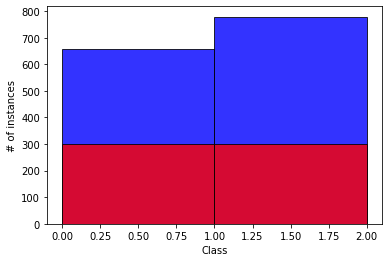

In [4]:
h1 = plt.hist(training_set.classes, bins=range(0,3), alpha=0.8, color='blue', edgecolor='black')
h2 = plt.hist(test_set.classes,  bins=range(0,3), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')

(128, 128, 128, 3) (128,)


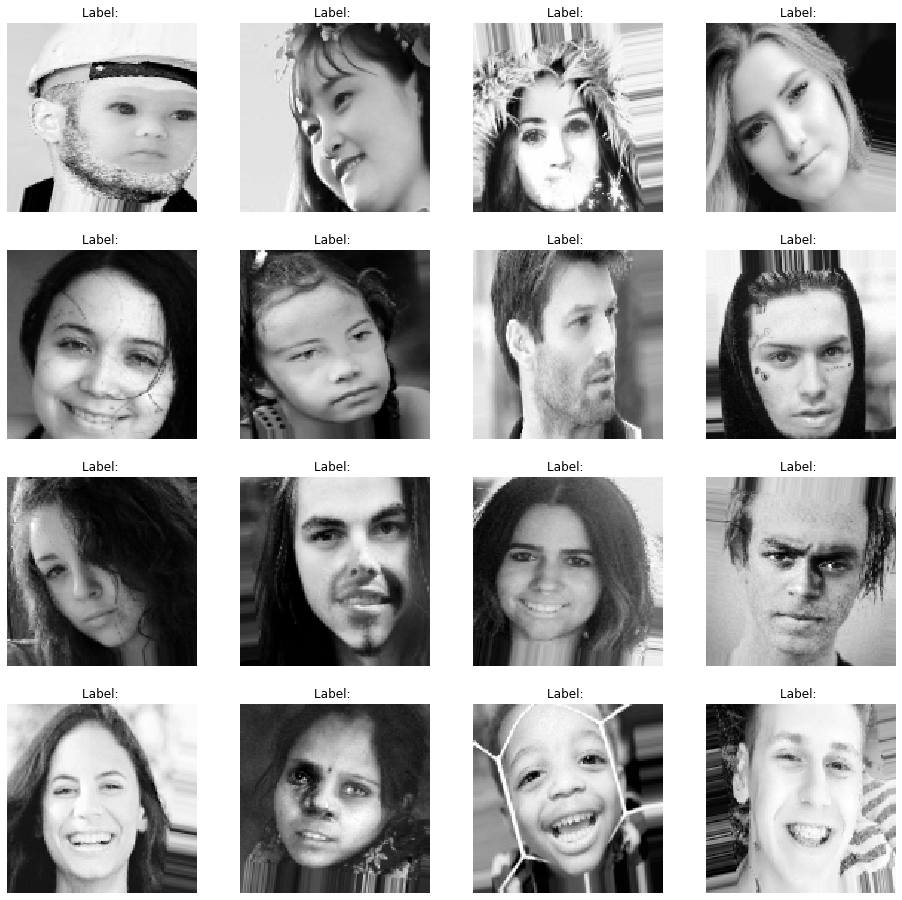

In [5]:
for X, y in training_set:
    print(X.shape, y.shape)
    plt.figure(figsize=(16,16))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.title('Label: ')
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

# Convolutional Neural Net
The data looks resonable so now I will define a CNN model to train and use within our application.

In [6]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(128,128,3)))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(activation="relu",
                units=256))

model.add(Dense(activation="sigmoid",
                units=1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
__________

##### Compile the model

In [7]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Training
Finally we will train our model using some keras helper functions. We are not doing any hyper-parameter optimization so we will not define a separate testing and validation set. We can however evaluate our model further in real time within the application.

In [8]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model_checkpoint.hdf5', monitor='val_loss', save_best_only=True, mode ='max'),
]

In [9]:
history = model.fit_generator(
        training_set,
        steps_per_epoch=80,
        epochs=10,
        validation_data=test_set,
        validation_steps=28,
        callbacks = callbacks_list
    )

Epoch 1/10
80/80 [==============================] - 229s 3s/step - loss: 0.7244 - acc: 0.5296 - val_loss: 0.6932 - val_acc: 0.5009
Epoch 2/10
80/80 [==============================] - 206s 3s/step - loss: 0.6902 - acc: 0.5412 - val_loss: 0.6845 - val_acc: 0.5561
Epoch 3/10
80/80 [==============================] - 200s 3s/step - loss: 0.6810 - acc: 0.5611 - val_loss: 0.6925 - val_acc: 0.5538
Epoch 4/10
80/80 [==============================] - 211s 3s/step - loss: 0.6734 - acc: 0.5760 - val_loss: 0.6761 - val_acc: 0.5787
Epoch 5/10
80/80 [==============================] - 203s 3s/step - loss: 0.6598 - acc: 0.5986 - val_loss: 0.6698 - val_acc: 0.6158
Epoch 6/10
80/80 [==============================] - 205s 3s/step - loss: 0.6438 - acc: 0.6186 - val_loss: 0.6642 - val_acc: 0.6451
Epoch 7/10
80/80 [==============================] - 208s 3s/step - loss: 0.6293 - acc: 0.6316 - val_loss: 0.6689 - val_acc: 0.6128
Epoch 8/10
80/80 [==============================] - 212s 3s/step - loss: 0.6024 - a

In [10]:
training_set.class_indices

{'fake': 0, 'real': 1}

Text(0.5, 0, '# of epochs')

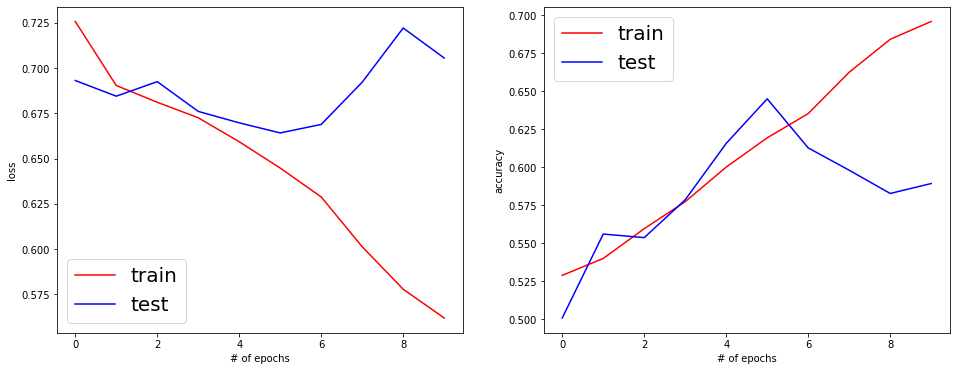

In [11]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('# of epochs')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['acc'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_acc'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('# of epochs')

# Prediction
Now the model is trained so I used some real images and edited that image so that we can analysis model is working correcly or not.

In [32]:
def ImagePrediction(loc):
    test_image = image.load_img(loc, target_size = (128,128))
    plt.axis('off')
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis =0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        predictions = 'Real'
    else:
        predictions = 'Fake'
    print('Prediction: ',predictions)

Enter Location of Image to predict: dataset/face_pred/check.jpg
Prediction:  Real


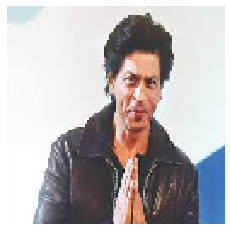

In [38]:
img = input("Enter Location of Image to predict: ")
test_image_1 = ImagePrediction(img)

Enter Location of Image to predict: dataset/face_pred/check2.jpg
Prediction:  Fake


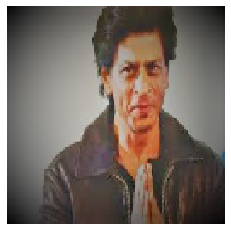

In [44]:
img = input("Enter Location of Image to predict: ")
test_image_2 = ImagePrediction(img)

Enter Location of Image to predict: dataset/face_pred/check3.jpg
Prediction:  Real


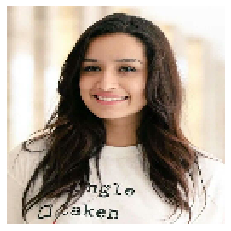

In [40]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

Enter Location of Image to predict: dataset/face_pred/check4.jpg
Prediction:  Real


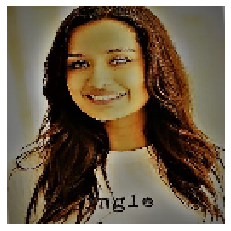

In [43]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

## Result
3 out of 4 images is predicted correctly althrough model is not trained well by incereasing epoc near about 40 will probably make this model perfectly trained but that will require 5-6hr for training.